# Mask R-CNN - Inspect Ballon Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import json
import os
import sys
import cv2
import skimage.color
from numpy import random
from keras.preprocessing import image
import numpy as np
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from keras.models import load_model

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
import matplotlib as mpl

from samples.flowchart import flowchart

%matplotlib inline

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
FLOWCHART_WEIGHTS_PATH = "mask_rcnn_balloon.h5"  # TODO: update this path

Using TensorFlow backend.
C:\Users\CADuser\anaconda3\envs\FlowchartMRCNN\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\CADuser\anaconda3\envs\FlowchartMRCNN\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\CADuser\anaconda3\envs\FlowchartMRCNN\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\CADus

## Configurations

In [2]:
config = flowchart.FlowchartConfig()
FLOWCHART_DIR = os.path.join(ROOT_DIR, "FlowchartDataMRCNN")

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                24
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [6]:
# Load validation dataset
dataset = flowchart.FlowchartDataset()
dataset.load_flowcharts(FLOWCHART_DIR, "TestingImages")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

C:\Users\CADuser\Documents\johanna\FlowchartMRCNN\FlowchartDataMRCNN\TestingImages
Images: 3
Classes: ['BG', 'terminal_start', 'flowline', 'input', 'decision', 'process', 'terminal_end', 'process_end', 'process_start', 'connector', 'document', 'terminal']


## Load Model

In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [8]:
# Set path to flowchart weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained
weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  C:\Users\CADuser\Documents\johanna\FlowchartMRCNN\logs\flowchart20200609T1207\mask_rcnn_flowchart_0030.h5
Re-starting from epoch 30


## Run Detection

image ID: flowchart.00000055.jpg (1) C:\Users\CADuser\Documents\johanna\FlowchartMRCNN\FlowchartDataMRCNN\TestingImages\00000055.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 24)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


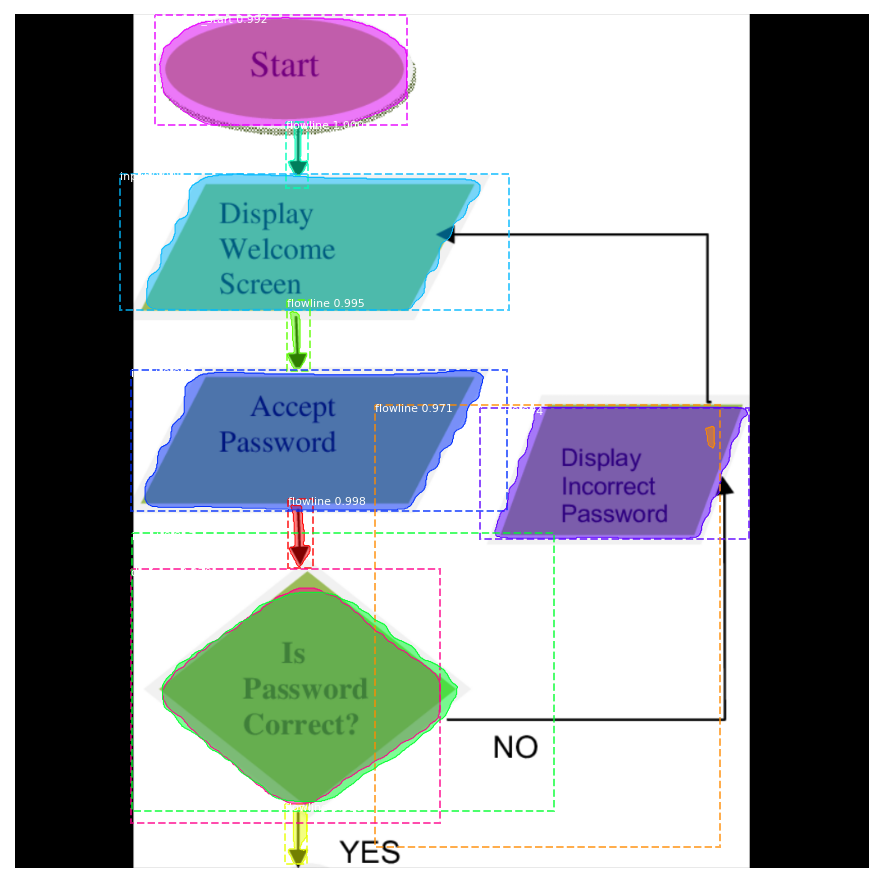

gt_class_id              shape: (11,)                 min:    1.00000  max:    4.00000  int32
gt_bbox                  shape: (11, 4)               min:    0.00000  max: 1024.00000  int32
gt_mask                  shape: (1024, 1024, 11)      min:    0.00000  max:    1.00000  bool


In [30]:
##Change from image to img_list where img_list==BATCH_SIZE (BS == IMAGES_PER_GPU * GPU_COUNT) to run on multiple GPUs
image_ids = random.choice(dataset.image_ids, config.BATCH_SIZE)

images = []
for image_id in image_ids:
    ima, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    info = dataset.image_info[image_id]
    images.append(ima)
    print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect(images, verbose=1)
#masks = []
for i, im in enumerate(images):
    r = results[i]
    #masks.append(r['masks'])
    visualize.display_instances(im, r['rois'], r['masks'], r['class_ids'],
                                dataset.class_names, r['scores'])
    log("gt_class_id", gt_class_id)
    log("gt_bbox", gt_bbox)
    log("gt_mask", gt_mask)

In [31]:
# def index_masks(mask1, mask2):
#     m1index = []
#     m2index = []
#
#     for index, m in enumerate(mask1.flatten()):
#         if m:
#             m1index.append(index)
#     for ind, n in enumerate(mask2.flatten()):
#         if n:
#             m2index.append(ind)
#
#     return m1index, m2index
#
# def masks_overlap(mask1, mask2):
#     m1index, m2index = index_masks(mask1, mask2)
#     for number in m1index:
#         if number in m2index:
#             return True
#     return False

In [32]:
# def find_start_mask_id(class_ids, start_terminal):
#     for index, id in enumerate(class_ids):
#         if id == start_terminal:
#             return index
#     return False

In [33]:
# def find_diff(mask1, mask2):
#     m1index, m2index = index_masks(mask1, mask2)
#     resultArray = []
#     for number1 in m1index:
#          for number2 in m2index:
#             result = number1 - number2
#             resultArray.append(result)
#     # print(resultArray)
#     # print(np.shape(resultArray))
#     # print(abs(sum(resultArray)))
#     return abs(sum(resultArray))


# def find_next_mask(class_ids, masks, current_index, flowchart_mask_order):
#     next_index = None
#     next_id = None
#     for index, id in enumerate(class_ids):
#         if index != current_index and index not in flowchart_mask_order:
#             potential_mask = masks[:, :, index]
#             current_mask = masks[:, :, current_index]
#             overlap = masks_overlap(current_mask, potential_mask)
#             #print(overlap)
#             if overlap:
#                 next_index = index
#                 next_id = id
#                 break
#
#     if next_index is None and next_id is None:
#         diff_dict = dict()
#         for index, id in enumerate(class_ids):
#             if index != current_index and index not in flowchart_mask_order:
#                 potential_mask = masks[:, :, index]
#                 current_mask = masks[:, :, current_index]
#                 diff = find_diff(current_mask, potential_mask)
#                 diff_dict.update({index: diff})
#         print("Diff Dict Minimum Value:")
#         print(min(diff_dict.values()))
#         print("Diff Dict Minimum Key:")
#         print(min(diff_dict.keys()))
#         print("Minimum Class ID:")
#         print(class_ids[min(diff_dict.keys())])
#         next_index = min(diff_dict.keys())
#         next_id = class_ids[min(diff_dict.keys())]
#
#     # print("current index: ")
#     # print(current_index)
#     # print("next index: ")
#     # print(next_index)
#     return next_index, next_id

In [34]:
# def build_flowchart_order(class_ids, masks, current_index, flowchart_class_order, flowchart_mask_order):
#     # print("current index: ")
#     # print(current_index)
#     next_index, next_id = find_next_mask(class_ids, masks, current_index, flowchart_mask_order)
#     # print("next index: ")
#     # print(next_index)
#     if next_index is not None and next_id is not None:
#         if next_index not in flowchart_mask_order:
#             flowchart_class_order.append(next_id)
#             flowchart_mask_order.append(next_index)
#             build_flowchart_order(class_ids, masks, next_index, flowchart_class_order, flowchart_mask_order)
#
#     return flowchart_class_order, flowchart_mask_order


In [35]:
# iterate through masks
# find mask which overlaps the start mask (start terminal)

r = results[0]
masks = r['masks']
class_ids = r['class_ids']


0
1
2
3
4
5
6
7
8
9


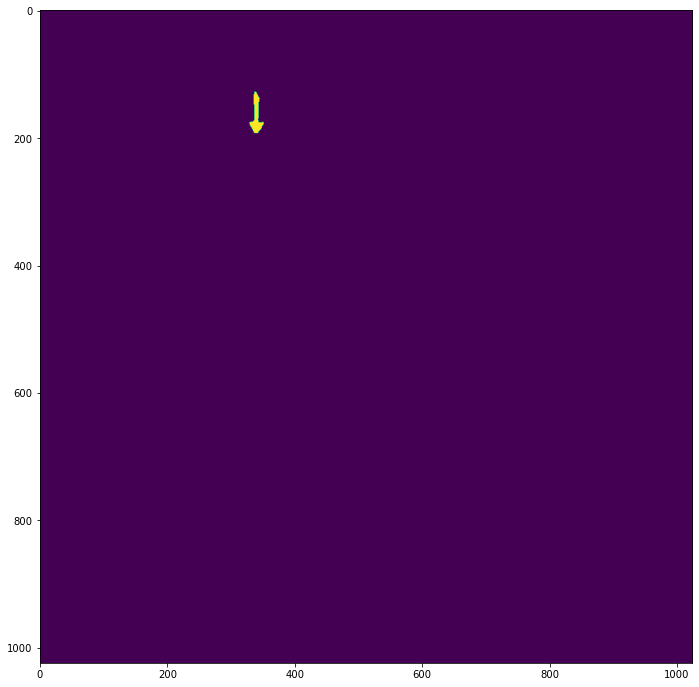

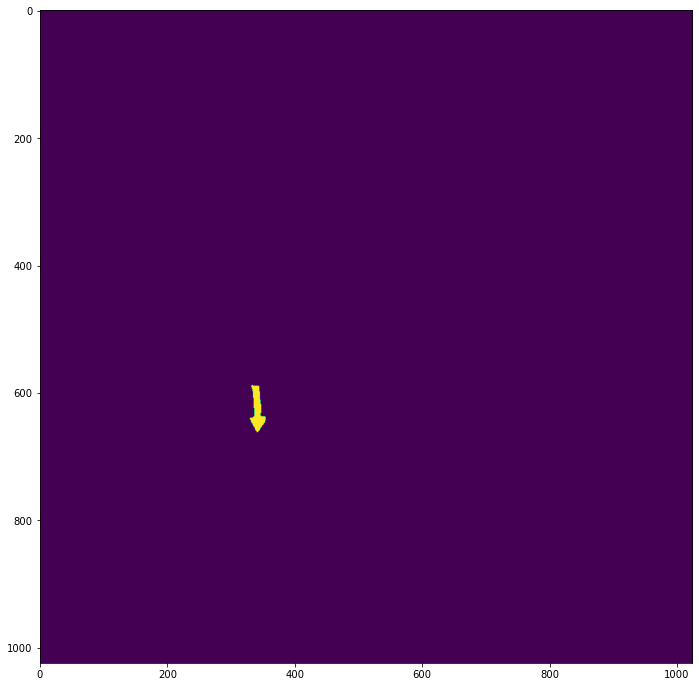

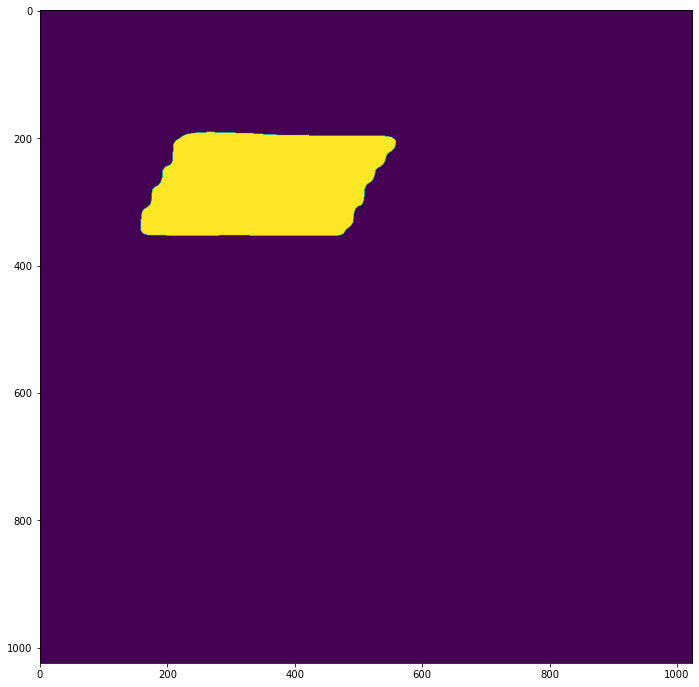

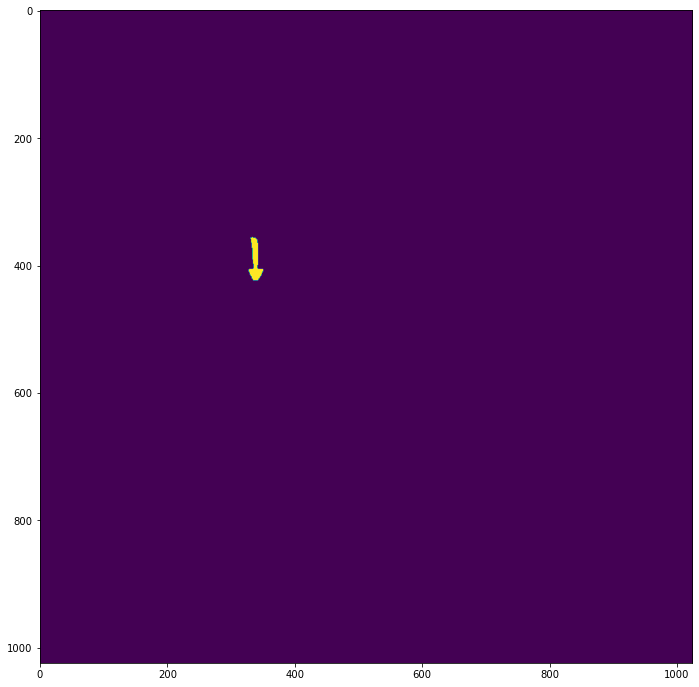

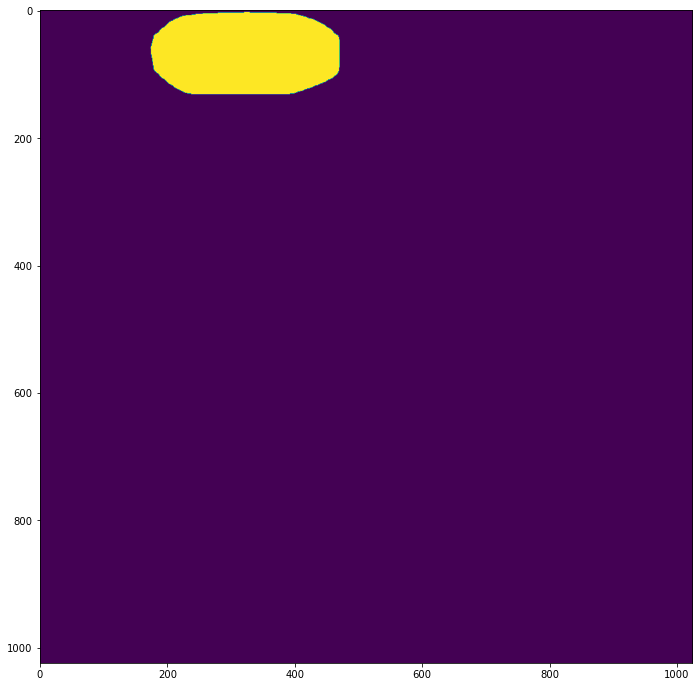

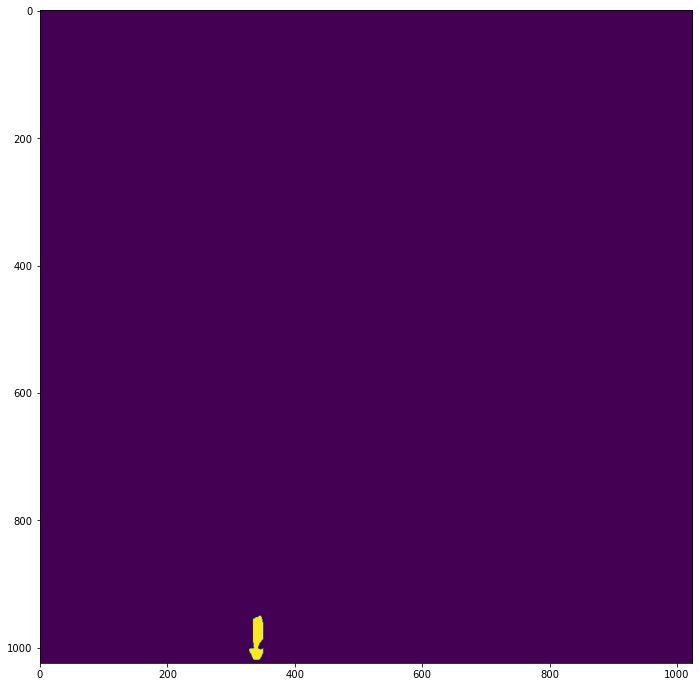

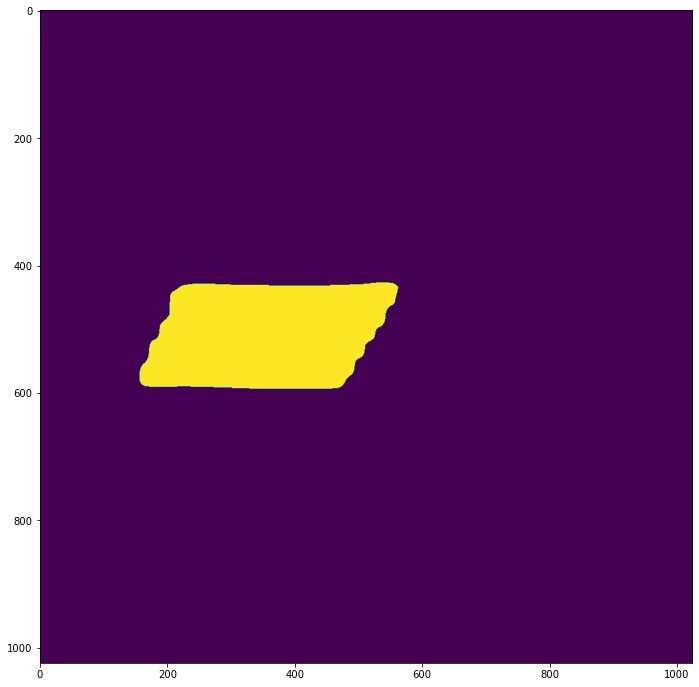

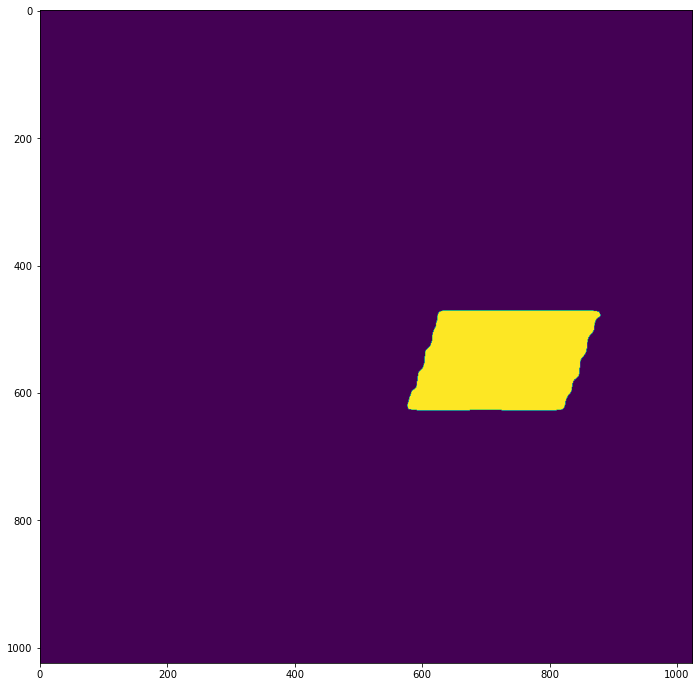

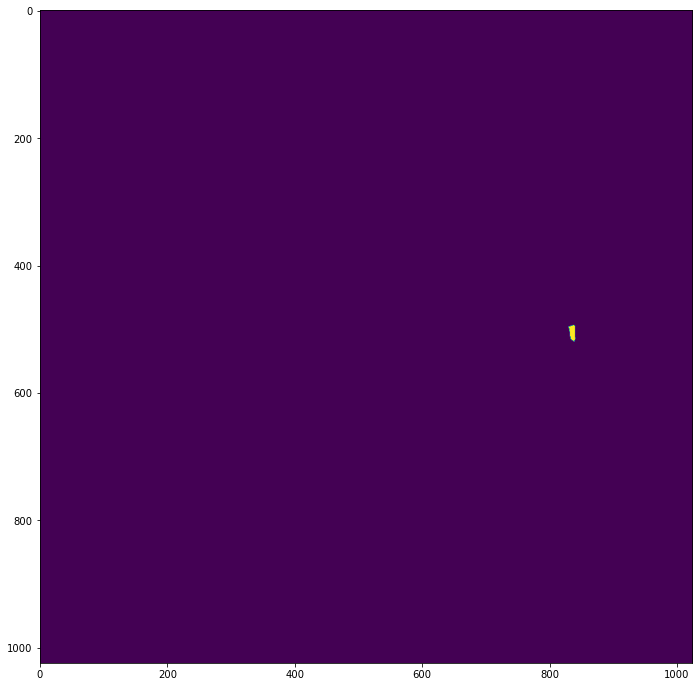

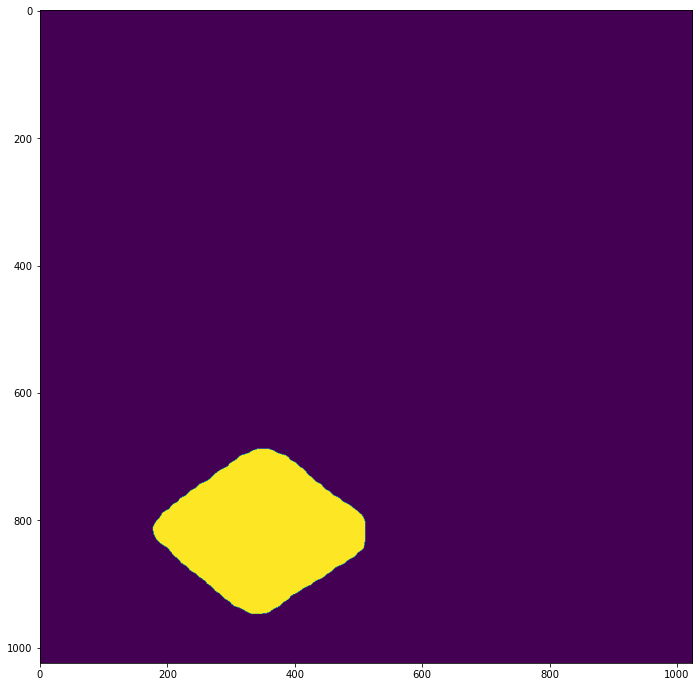

In [36]:
for i in range(0,masks.shape[2]-1):
    print(i)
    next_mask = masks[:, :, i]
    plt.figure(figsize=(12, 12))
    plt.imshow(next_mask)


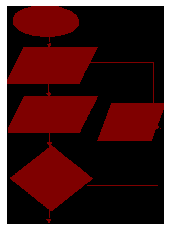

In [37]:
for image_id in image_ids:
    masks, class_ids = dataset.load_mask(image_id)
    x = np.zeros((masks.shape[0], masks.shape[1]))
    plt.imshow(x, cmap=mpl.cm.bone)
    for i in range(0,masks.shape[2]):
        currentMask = masks[:,:,i]
        currentMask = np.ma.masked_where(currentMask == 0, currentMask)
        plt.imshow(currentMask, cmap=mpl.cm.jet_r, interpolation='nearest')
    # plt.show()
    imageName = '0000000' + str(image_id) + '.jpg'
    plt.axis('off')
    plt.savefig(imageName, bbox_inches='tight', pad_inches=0)


In [33]:
class_ids_as_list = [class_ids]
# for i in range(0,class_ids.shape[0]):
#     class_ids_as_list.append(np.ones(len(class_ids[i])))
# class_ids_as_np = np.asarray(class_ids_as_list)

#TODO: put maxlen from Neural net dynamically
x_test_symbols = tf.keras.preprocessing.sequence.pad_sequences(
    class_ids_as_list, maxlen=40, padding="post")
print(x_test_symbols)

[[2 2 2 2 5 4 5 2 2 4 5 5 2 6 2 2 5 4 5 5 5 5 2 1 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0]]


In [34]:
x_test_pics = []
image_name = ''
for image_id in image_ids:
    info = dataset.image_info[image_id]
    image_name= info['id']
print(np.shape(images))
image_path = '../../FlowchartDataMRCNN/TestingImages/' + image_name
img = image.load_img(image_path, color_mode='grayscale', target_size=(250, 250))
print(np.shape(img))
x = image.img_to_array(img)
print(np.shape(x))
x_test_pics.append(x)

(1, 1024, 1024, 3)
(250, 250)
(250, 250, 1)


In [37]:
model = load_model('../../model_sorting_weights/model_weights.h5')
prediction = model.predict([np.asarray(x_test_symbols), np.asarray(x_test_pics)])
print(prediction)
print([np.asarray(x_test_symbols).reshape(40, )
       [np.abs(np.asarray(x_test_symbols).reshape(40, ) - i).argmin()] for i in list(prediction[0])])

[[ 2.6780515   1.7015935   4.2941685   2.2407897   3.4444344   1.936697
   4.771624    1.3912348   5.0587626   2.8790796   3.8790064   2.7827954
   4.0141864   2.2464278   3.0991747   1.8951999   2.6434913   2.7735837
   2.9881918   1.6162952   2.2007625   0.6859197   0.9144381   0.16038074
   1.2603184   0.03935742  0.04871222  0.24900034  0.2024055   0.5783563
   0.5148523   1.0077889   0.19561455  1.0948956   0.80241996  1.5837998
  -0.05529879  0.44912353  0.04230233  0.02452128]]
[2, 2, 4, 2, 4, 2, 5, 1, 5, 2, 4, 2, 4, 2, 4, 2, 2, 2, 2, 2, 2, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 0, 0, 0]
